# Model-based EM algorithm
**Clustering of polynomial curve**

(This was not apart of the coursework but a inspiration I had while doing a research course)

Potential relevant reading: https://arxiv.org/abs/1312.7022

### Some observational notes
- Performs well when it matches the underlying distribution (duh)
- Seems to be better than hierarchical clustering when there is underlying structure (e.g. temporal) _but_ the datapoints are very close together
- Have observed hierarchical clustering perform better when there are clear distinctions between groups, not entirely sure why yet

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Define polynomial function

In [2]:
# Function
polyFunc = lambda t,b0,b1,b2: b0 + b1*(t) + b2*(t**2)

### Simulate data

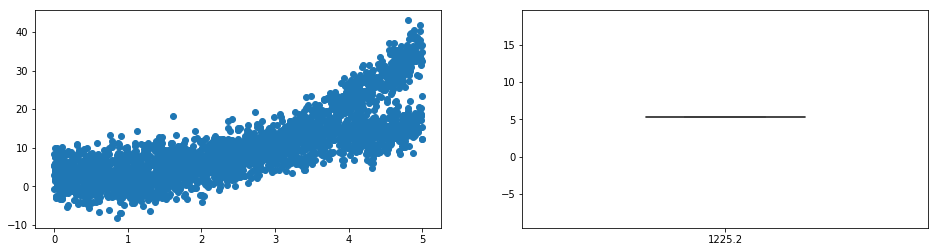

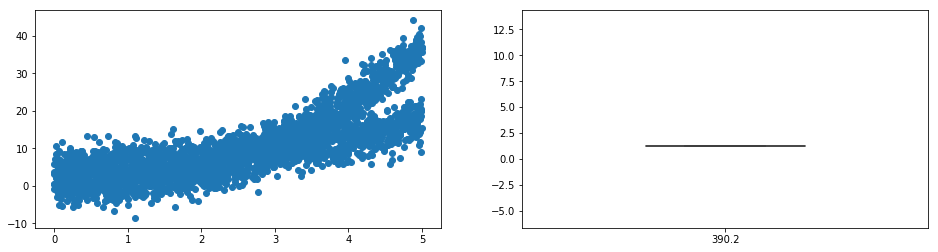

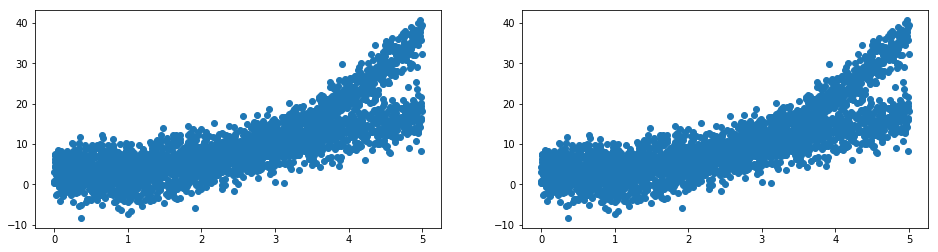

In [5]:
## Curve generation ##

# Samples per class
N_Samples = 300
T_points = 5

# Set the parameters of the curves
c0_b0, c0_b1, c0_b2 = 2.0, -3, 2
c1_b0, c1_b1, c1_b2 = 4.0, 1.0, 0.3


# Generate the X values
simX = np.random.uniform(low=0.0, high=5.0, size=(N_Samples*2, T_points))
#simX = np.repeat(np.array([0.5, 1.2, 2.0, 2.2, 3.2]).reshape(1,T_points), (2*N_Samples), axis=0)

# Generate the Y values
clean_Y = np.zeros((N_Samples*2, T_points))
for i in range(0, N_Samples):
    for j in range(0,T_points):
        clean_Y[i,j] = polyFunc(simX[i,j], c0_b0, c0_b1, c0_b2)
for i in range(N_Samples, len(clean_Y)):
    for j in range(0,T_points):
        clean_Y[i,j] = polyFunc(simX[i,j], c1_b0, c1_b1, c1_b2)

# Add noise to y
gaus_noise = np.random.normal(loc=0.0, scale=3, size=(N_Samples*2, T_points))
noisy_Y = np.add(clean_Y, gaus_noise)


## Initialize the ground truth labels ##
grounTruth = np.empty((2*N_Samples))
grounTruth[0:N_Samples] = 0
grounTruth[N_Samples:] = 1
    
## Visualize the points ##
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.scatter(simX, noisy_Y)
plt.subplot(1,2,2)
#sns.boxplot(x=simX.flatten(), y=noisy_Y.flatten(), hue=np.repeat(grounTruth,T_points))
plt.scatter(simX, noisy_Y)
plt.show()

## Model-based EM Algorithm

In [6]:
## Algorithm ##
from scipy.optimize import curve_fit

# Log of Gaussian likelihood:
# https://math.stackexchange.com/questions/1307381/logarithm-of-gaussian-function-is-whether-convex-or-nonconvex
def univarLogGausLikelihood(x, mu, sigma=1.0):
    A = np.log( np.divide(1.0, (np.sqrt(2 * np.pi) * sigma)) )
    B = np.square(x-mu) / (2 * np.square(sigma))
    return A - B

##
# Given a high-dimensional data, compute the likelihood at each timepoint
##
def elementWiseLogGaussianLikelihood(observMat, muMat, sigma):
    likelihoodMat = np.empty(np.shape(muMat))
    for rowIdx in range(np.shape(observMat)[0]):
        for colIdx in range(np.shape(observMat)[1]):
            likelihoodMat[rowIdx, colIdx] = univarLogGausLikelihood(observMat[rowIdx,colIdx],
                                                                    muMat[rowIdx,colIdx],
                                                                    sigma)
    return likelihoodMat


# Standard deviation (sigma) of a group TODO: parameter is hard-coded
def computeClusterSigma(y, func, x, a, b, c):
    # Compute the predicted y for each x
    pred_y = np.zeros(np.shape(y))
    for i in range(len(x)):
        pred_y[i] = func(x[i], a, b, c) 
    
    # Compute differences
    abs_diff = np.abs( np.subtract(pred_y, y) )
    return np.average(abs_diff)


    
    
###
# Soft EM on polynomial curves
# X and Y are both 2D matrices indexed by [subject, timepoint]
###
def polynomialEM(X, Y, deg=2, n_clusters=2, max_iters=20):
    ## Initialization of parameters ##
    # Initialize the coefficients of the polynomial model
    polyCoefs = np.random.normal(loc=0.0, scale=2.0, size=(deg+1, n_clusters))
    # Initialize the variance (NOTE: hard-coded to be fixed at one)
    varVec = np.ones(n_clusters)*20.0
    
    # Power-ed up X matrix containing [subject, timepoints, polynomial degree]
    powerX = np.empty((np.shape(X)[0],np.shape(X)[1],deg+1))
    for degIdx in range(deg+1):
        powerX[:,:,degIdx] = np.power(X,degIdx)
    
    # Array denoting the (log) likelihood of each sample to each class ([individual, class likelihood])
    logPosteriorMat = np.zeros((len(X),n_clusters))
    totPosteriorTraj = np.zeros(max_iters)
    
    ## Start iteration ##
    for iterIdx in range(max_iters):
        print('Iteration %d out of %d' % (iterIdx+1, max_iters))
        ## Expectation step ##
        # Estimate the value of y (dot X and beta) at each timepoint
        esti_Y = np.empty((np.shape(X)[0],np.shape(X)[1], n_clusters))
        for m in range(np.shape(X)[1]):
            esti_Y[:,m,:] = np.dot(powerX[:,m,:], polyCoefs)
        # Compute the likelihood at each timepoint ([subject, timepoint, class likelihood])
        elementWiseL = np.empty((np.shape(X)[0],np.shape(X)[1],n_clusters))
        for k in range(n_clusters):
            elementWiseL[:,:,k] = elementWiseLogGaussianLikelihood(Y, esti_Y[:,:,k],varVec[k])
        
        # Compute the class-wise log posterior per element
        logPosteriorMat = np.sum(elementWiseL, axis=1)
        # Total posterior this iteration
        totPosteriorTraj[iterIdx] = np.sum(logPosteriorMat)
        
        # Laplace smoothing the likelihood (ended up abandoning this since it is actually in log-space
        # so it doesn't make sense)
        #smoothedElementL = np.add(elementWiseL, 1.0)
        # ... (deleted)
        
        
        ## Maximization ##
        # Convert the log probability back into normal probability normalize for weighted polynomial fit
        normPosteriorMat = np.exp(logPosteriorMat)
        sumNormPostVec = np.sum(normPosteriorMat, axis=1).flatten()
        weightMat = normPosteriorMat / sumNormPostVec[:,None] # normalizing division
        
        # Re-shape the X and Y to be time-invariant
        flat_X = X.flatten()
        flat_Y = Y.flatten()
        weightMat = np.repeat(weightMat, repeats=np.shape(X)[1], axis=0)
        # Weighted polynomial fitting for each class
        for k in range(n_clusters):
            fitCoefs = np.polynomial.polynomial.polyfit(flat_X, flat_Y, deg=deg, w=weightMat[:,k])
            # Update parameters
            polyCoefs[:,k] = fitCoefs
        
        # Clean-up
        del esti_Y, elementWiseL
        del flat_X, flat_Y
        
    # Compute final label values and return
    finalLabIdxs = np.argmax(logPosteriorMat, axis=1)
    returnDict = {}
    returnDict['FinalLogPosteriors'] = logPosteriorMat
    returnDict['PosteriorOverTime'] = totPosteriorTraj
    returnDict['Labels'] = finalLabIdxs
    returnDict['Coefs'] = polyCoefs
    
    return returnDict
    
        
        

### Test algorithm

In [7]:
# Run the model
fittedDict = polynomialEM(simX, noisy_Y, deg=2, n_clusters=2, max_iters=5)

Iteration 1 out of 5
Iteration 2 out of 5
Iteration 3 out of 5
Iteration 4 out of 5
Iteration 5 out of 5


Number correct: 576/600; Accuracy = 0.960000
Last iteration log prob: -23650.745447


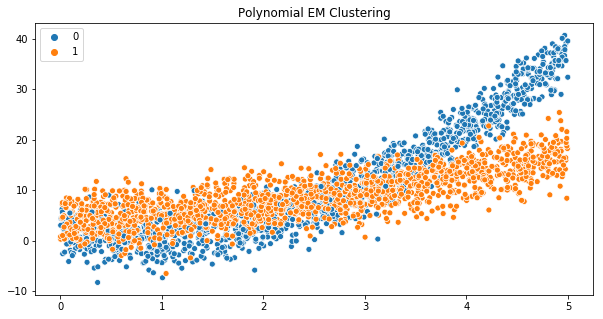

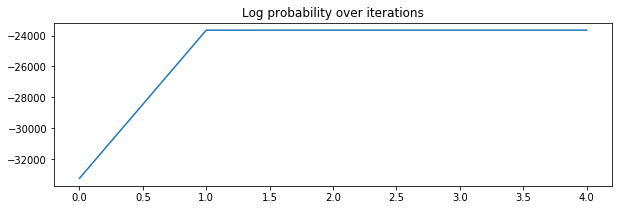

In [14]:
## Compute the ground-truth label ##
def printAccuracy(trueLabel, predLabel):
    num_samples = len(trueLabel)
    numCorrect = np.sum(trueLabel == predLabel)
    if numCorrect < (num_samples/2):
        numCorrect = num_samples - numCorrect
    print('Number correct: %d/%d; Accuracy = %f' % (numCorrect, num_samples, (numCorrect/(num_samples))))

## Evaluate accuracy ##
printAccuracy(grounTruth, fittedDict['Labels'])

## Look at log probability ##
print('Last iteration log prob: %f' % fittedDict['PosteriorOverTime'][-1])

## Plot ##
plt.figure(figsize=(10,5))
sns.scatterplot(x=simX.flatten(), y=noisy_Y.flatten(), hue=np.repeat(fittedDict['Labels'],T_points))
#sns.boxplot(x=simX.flatten(), y=noisy_Y.flatten(), hue=np.repeat(fittedDict['Labels'],T_points))
plt.title('Polynomial EM Clustering')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(fittedDict['PosteriorOverTime'])
plt.title('Log probability over iterations')
plt.show()

### Compare against hierarchical clustering

Number correct: 399/600; Accuracy = 0.665000


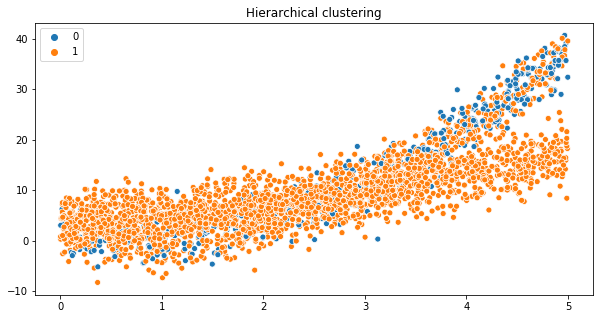

In [13]:
from sklearn.cluster import AgglomerativeClustering

## ##
aggloClustering = AgglomerativeClustering()
aggloLabels = aggloClustering.fit_predict(noisy_Y)

## Evaluate and visualize ##
printAccuracy(aggloLabels, fittedDict['Labels'])

plt.figure(figsize=(10,5))
#sns.boxplot(x=simX.flatten(), y=noisy_Y.flatten(), hue=np.repeat(aggloLabels,T_points))
sns.scatterplot(x=simX.flatten(), y=noisy_Y.flatten(), hue=np.repeat(aggloLabels,T_points))
plt.title('Hierarchical clustering')
plt.show()

del aggloClustering, aggloLabels

In [ ]:
from sklearn.cluster import AgglomerativeClustering

## ##
aggloClustering = AgglomerativeClustering()
aggloLabels = aggloClustering.fit_predict(clean_Y)

## Evaluate and visualize ##
printAccuracy(aggloLabels, fittedDict['Labels'])

plt.figure(figsize=(10,5))
sns.boxplot(x=simX.flatten(), y=noisy_Y.flatten(), hue=np.repeat(aggloLabels,T_points))
plt.title('Hierarchical clustering on clean data')
plt.show()

del aggloClustering, aggloLabels

### Compare against fitting then clustering

In [ ]:
from scipy.optimize import curve_fit

## Iterate through each point to fit ##
fittedParamFeats = np.empty((len(simX),3))

for i in range(len(simX)):
    # Take the xVec and yVec
    curXVec = simX[i,:]
    curYVec = noisy_Y[i,:]
    # Fit line
    param, cov = curve_fit(polyFunc, curXVec, curYVec)
    # Save parameters
    fittedParamFeats[i,:] = param


## Cluster the parameters ##
clustering = AgglomerativeClustering()
paramFitLabels = clustering.fit_predict(fittedParamFeats)

## Evaluate and visualize ##
printAccuracy(paramFitLabels, fittedDict['Labels'])

plt.figure(figsize=(10,5))
sns.boxplot(x=simX.flatten(), y=noisy_Y.flatten(), hue=np.repeat(paramFitLabels,T_points))
plt.title('Polynomial Line Fit --> Hierarchical Clustering ')
plt.show()

del clustering, paramFitLabels